# Rolling Signal Regression Model

1. Here is what is known. Trading Treasury futures conditioned on the lag signal generate substantail returns ```RawSignalBacktest.ipynb```
2. The presumption of \textit{conditioning} on the signal was verified in-sample ```OLSBetaSign.ipynb``` 
3. Sampled OLS $\beta$ using a series of simulations with 15% in-sample size showed that negative $\beta$s are likely to occur but some may be positive ```SignalDirectionTest.ipynb``` 

The sampled OLS model breaks the condition that sample must be ordered. In this case a rolling $\beta$ gives an ordered sample. There are two questions to work out in this notebook
1. How statistically different are the distributions of the rolling $\beta$ and sampled $\beta$.
2. If they are statistically different is a sampling error or does the model predict positive returns

Within the rolling $\beta$ framework two approaches were taken. 
1. Rolling Beta based on proportional window
2. Rolling Beta based on days lookback

Technically proportional window is the reasonable comparison.

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from SignalRollingBetaOLS import RollingBetaOLS
from SignalBootstrapBetaOLS import BootstrapBetaOLS

## Comparing Distribution of Betas

Start by creating the boxplots of each $\beta$

In [3]:
def get_data() -> pd.DataFrame: 
    
    df_rolling = (RollingBetaOLS().get_proportion().query(
        "prop == 0.15").
        drop(columns = ["window", "prop", "group_var"]).
        assign(group_var = lambda x: x.input_val + " " + x.variable))

    df_bootstrap = (BootstrapBetaOLS().sample_betas().assign(
        group_var = lambda x: x.input_val + " " + x.variable))
    
    return df_rolling, df_bootstrap

df_rolling, df_bootstrap = get_data()

Recreate the boxplots

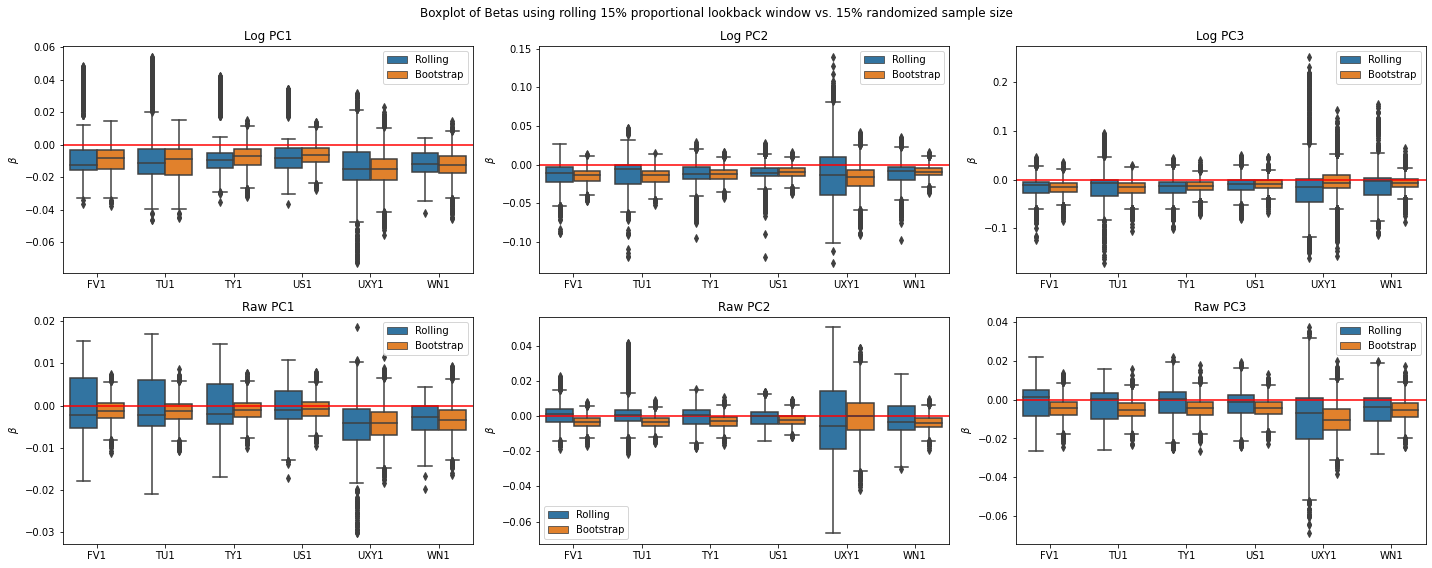

In [4]:
def plot_boxplot(df_rolling: pd.DataFrame, df_bootstrap: pd.DataFrame) -> plt.Figure: 
    
    group_vars = (df_rolling.group_var.drop_duplicates().sort_values())
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        df_rolling_tmp = (df_rolling.query(
            "group_var == @group_var")
            [["lag_beta", "security"]].
            rename(columns = {"lag_beta": "beta"}).
            assign(group = "Rolling"))

        df_bootstrap_tmp = (df_bootstrap.query(
            "group_var == @group_var")
            [["security", "beta"]].
            assign(group = "Bootstrap"))

        df_combined = (pd.concat([
            df_rolling_tmp, df_bootstrap_tmp]).
            rename(columns = {"group": ""}))

        sns.boxplot(
            data = df_combined,
            x    = "security",
            y    = "beta",
            hue  = "",
            ax   = ax)

        ax.set_title(group_var.replace(
            "_value", "").
            capitalize().
            replace("pc", "PC"))

        ax.set_ylabel(r"$\beta$"); ax.set_xlabel("")
        ax.axhline(y = 0, color = "red")

    fig.suptitle("Boxplot of Betas using rolling 15% proportional lookback window vs. 15% randomized sample size")
    plt.tight_layout()
    
plot_boxplot(df_rolling, df_bootstrap)

Now plot the full distribution

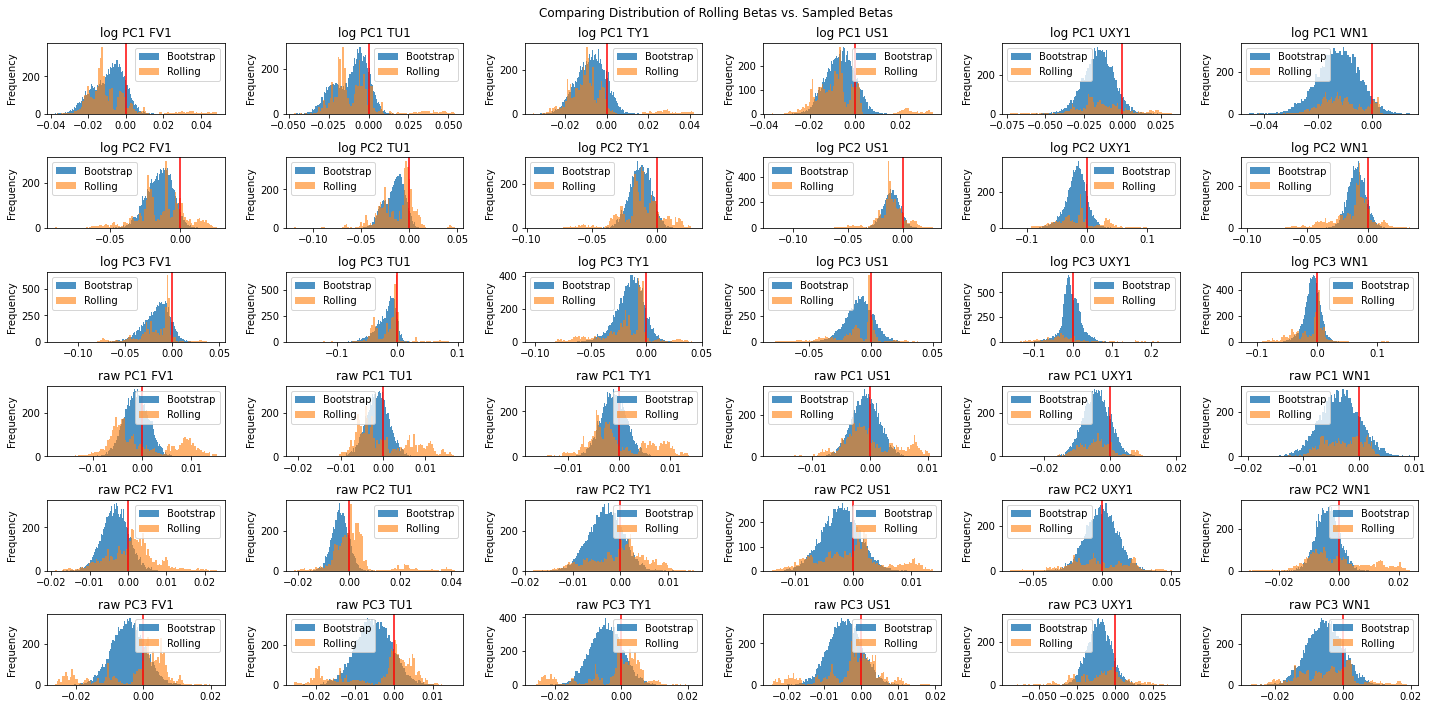

In [5]:
def plot_beta_distribution(df_rolling: pd.DataFrame, df_bootstrap: pd.DataFrame) -> plt.Figure: 
    
    df_rolling_tmp = (df_rolling.drop(
        columns = ["group_var"]).
        assign(group_var = lambda x: x.input_val + " " + x.variable + " " + x.security))

    df_bootstrap_tmp = (df_bootstrap.assign(
        group_var = lambda x: x.group_var + " " + x.security))

    group_vars = df_rolling_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 6, nrows = len(group_vars) // 6, figsize = (20,10))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_bootstrap_tmp.query(
            "group_var == @group_var").
            beta.
            plot(
                kind  = "hist",
                ax    = ax,
                bins  = 100,
                alpha = 0.8,
                label = "Bootstrap"))

        (df_rolling_tmp.query(
            "group_var == @group_var").
            beta.
            plot(
                kind  = "hist",
                ax    = ax,
                bins  = 100,
                alpha = 0.6,
                label = "Rolling",
                title = group_var.replace("_value", "")))

        ax.axvline(x = 0, color = "red")
        ax.legend()

    fig.suptitle("Comparing Distribution of Rolling Betas vs. Sampled Betas")
    plt.tight_layout()
    
plot_beta_distribution(df_rolling, df_bootstrap)

In this case since its more a binary question of positive or negative beta, count the proportion (in this case just the positive count).

In [6]:
def get_proportion(df_rolling: pd.DataFrame, df_bootstrap: pd.DataFrame) -> pd.DataFrame:
    
    df_rolling_tmp = (df_rolling[
        ["lag_beta", "group_var", "security", "date"]].
        assign(group = "rolling").
        rename(columns = {"lag_beta": "beta"}))

    df_bootstrap_tmp = (df_bootstrap[
        ["beta", "group_var", "security", "sim"]].
        assign(group = "bootstrap").
        rename(columns = {"sim": "date"}))

    df_proportion = (pd.concat([
        df_rolling_tmp, df_bootstrap_tmp]).
        assign(beta = lambda x: np.where(x.beta > 0, "Positive", "Negative")).
        groupby(["group_var", "beta", "security", "group"]).
        agg("count").
        reset_index().
        pivot(index = ["group_var", "security", "group"], columns = "beta", values = "date").
        assign(pos_prop = lambda x: x.Positive / (x.Positive + x.Negative)).
        reset_index())
    
    return df_proportion

df_proportion = get_proportion(df_rolling, df_bootstrap)

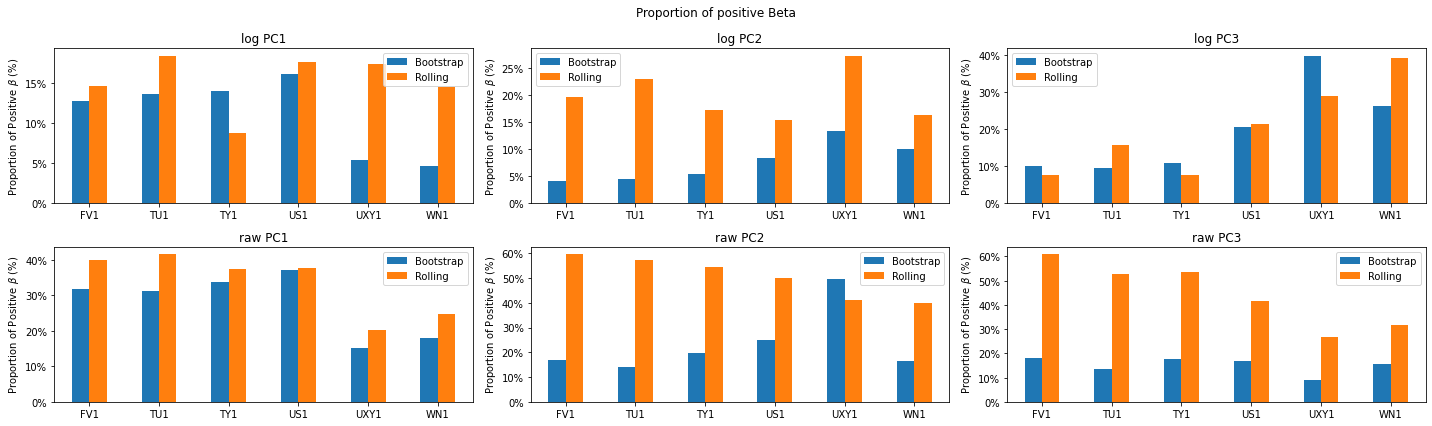

In [7]:
def plot_proportion(df_proportion: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_proportion.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_proportion.query(
            "group_var == @group_var").
            assign(group = lambda x: x.group.str.capitalize()).
            rename(columns = {"group": ""}).
            pivot(index = "security", columns = "", values = "pos_prop").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                title  = group_var.replace("_value", ""),
                ylabel = r"Proportion of Positive $\beta$ (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Proportion of positive Beta")
    plt.tight_layout()
    
plot_proportion(df_proportion)

There are times when the $\beta$ flips which means that the relationship goes the other way. Now investigate what actually happens <br>
1. Does the actual relationship flip? Liekly not since the p-values for the in-samples passed, this can be tested by looking at the performance conditioned on a positive $\beta$
2. Is the conditioned data for the OLS just bad and the time-order of the data can throw off the model.

In [8]:
def get_pos_sharpe(df_rolling: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_rolling.query(
        "lag_beta > 0").
        assign(signal_rtn = lambda x: x.lag_spread * x.PX_bps)
        [["group_var", "security", "signal_rtn"]].
        groupby(["security", "group_var"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_pos_sharpe(df_rolling)

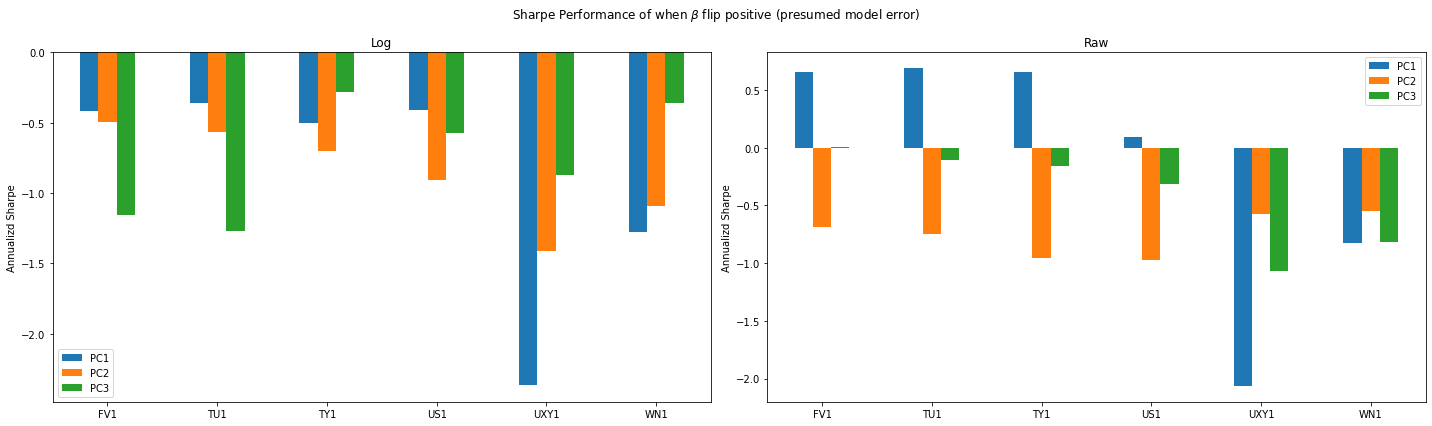

In [9]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_sharpe.assign(
        input_val = lambda x: x.group_var.str.split(" ").str[0],
        pc        = lambda x: x.group_var.str.split(" ").str[1]))

    input_vals = df_tmp.input_val.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(input_vals), figsize = (20,6))

    for input_val, ax in zip(input_vals, axes.flatten()): 

        (df_tmp.query(
            "input_val == @input_val").
            rename(columns = {"pc": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                rot    = 0,
                ylabel = "Annualizd Sharpe",
                title  = input_val.split("_")[0].capitalize()))

    fig.suptitle(r"Sharpe Performance of when $\beta$ flip positive (presumed model error)")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)